#Project<br>
Group Members:<br>
1. Amna Masood (52213124924)<br>
2. Damia Hannah Binti Md Nasair (52213124567)

#Data Engineer : Data preparation

Dataset Domain: Medical imaging





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/PAI

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/PAI


In [ ]:
#import libraries
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools

#keras tools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Small
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess

# metrics to get mAP
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ', len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [ ]:
#dataset path
DATASET_DIR = "AcneDataset"

train_path = os.path.join(DATASET_DIR, "train")
valid_path = os.path.join(DATASET_DIR, "valid")
test_path  = os.path.join(DATASET_DIR, "test")

classes = ['Blackheads', 'Cyst', 'Papules', 'Pustules', 'Whiteheads']

#Data Scientist: Data Modelling



#Create Data Generators

In [ ]:
#data generators (Resnet50 model 1)
# Training data (with augmentation)
train_gen_resnet = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,  # STANDARDIZATION
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
).flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=classes,
    shuffle=True
)

# Validation data (NO augmentation)
valid_gen_resnet = ImageDataGenerator(
    preprocessing_function=resnet_preprocess
).flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=classes,
    shuffle=False
)

# Test data (NO augmentation)
test_gen_resnet = ImageDataGenerator(
    preprocessing_function=resnet_preprocess
).flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=classes,
    shuffle=False
)

Found 2778 images belonging to 5 classes.
Found 921 images belonging to 5 classes.
Found 918 images belonging to 5 classes.


In [ ]:
#data generators (Dense121 model 2)
# Training data (with augmentation)
train_gen_densenet = ImageDataGenerator(
    preprocessing_function=densenet_preprocess,  # STANDARDIZATION
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
).flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=classes,
    shuffle=True
)

# Validation data (NO augmentation)
valid_gen_densenet = ImageDataGenerator(
    preprocessing_function=densenet_preprocess
).flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=classes,
    shuffle=False
)

# Test data (NO augmentation)
test_gen_densenet = ImageDataGenerator(
    preprocessing_function=densenet_preprocess
).flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=classes,
    shuffle=False
)

Found 2778 images belonging to 5 classes.
Found 921 images belonging to 5 classes.
Found 918 images belonging to 5 classes.


In [ ]:
#data generators (MobileNetV3 model 3)
# Training data (with augmentation)
train_gen_mobilenet = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess,  # STANDARDIZATION
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
).flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=classes,
    shuffle=True
)

# Validation data (NO augmentation)
valid_gen_mobilenet = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess
).flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=classes,
    shuffle=False
)

# Test data (NO augmentation)
test_gen_mobilenet = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess
).flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=classes,
    shuffle=False
)

Found 2778 images belonging to 5 classes.
Found 921 images belonging to 5 classes.
Found 918 images belonging to 5 classes.


In [ ]:
#validate total number of training image as found above
assert train_gen_resnet.n == 2778
assert valid_gen_resnet.n == 921
assert test_gen_resnet.n == 918
assert train_gen_resnet.num_classes == valid_gen_resnet.num_classes == test_gen_resnet.num_classes == 5


#ResNet50 Model  

In [ ]:
# Phase 1: Transfer Learning (25 epochs with frozen base)
# 1. Create base model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_base.trainable = False #freeze all layers

# 2. Build custom classifier
inputs = tf.keras.Input(shape=(224, 224, 3))
x = resnet_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation='softmax')(x)

resnet_model = Model(inputs, outputs)

# 3. Compile model
resnet_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# 4. DISPLAY MODEL SUMMARY (before training) - frozen base
resnet_model.summary()

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

# START TIMER
start_time = time.time()

# PHASE 1 TRAINING (25 epochs) - transfer learning
history1_resnet = resnet_model.fit(
    train_gen_resnet,
    validation_data=valid_gen_resnet,
    epochs=25,
    callbacks=callbacks,
    verbose=2
)

# Phase 2: Fine-tuning (25 epochs with unfrozen layers)
# Unfreeze last 20 layers for fine-tuning
resnet_base.trainable = True
for layer in resnet_base.layers[:-20]:
    layer.trainable = False
for layer in resnet_base.layers[-20:]:
    layer.trainable = True

# Recompile with lower learning rate for fine-tuning
resnet_model.compile(optimizer=Adam(learning_rate=0.00001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# PHASE 2 TRAINING (25 epochs)
print("\nTraining Phase 2: 25 epochs (Fine-tuning)...")
history2_resnet = resnet_model.fit(
    train_gen_resnet,
    validation_data=valid_gen_resnet,
    epochs=25,
    callbacks=callbacks,
    verbose=2
)

# CALCULATE TOTAL TIME
resnet_training_time = time.time() - start_time

# COMBINE HISTORIES
resnet_history = {
    'accuracy': history1_resnet.history['accuracy'] + history2_resnet.history['accuracy'],
    'val_accuracy': history1_resnet.history['val_accuracy'] + history2_resnet.history['val_accuracy'],
    'loss': history1_resnet.history['loss'] + history2_resnet.history['loss'],
    'val_loss': history1_resnet.history['val_loss'] + history2_resnet.history['val_loss']
}

print(f"\n✓ ResNet50 training completed!")
print(f"✓ Total epochs: 50")
print(f"✓ Training time: {resnet_training_time:.2f} seconds")
print(f"✓ Phase 1: 25 epochs transfer learning")
print(f"✓ Phase 2: 25 epochs fine-tuning")
print(f"✓ Training history combined: {len(resnet_history['accuracy'])} epochs recorded")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,541 (91.99 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
87/87 - 1828s - 21s/step - accuracy: 0.4316 - loss: 1.4533 - val_accuracy: 0.5852 - val_loss: 1.0250 - learning_rate: 1.0000e-03
Epoch 2/25
87/87 - 55s - 629ms/step - accuracy: 0.5252 - loss: 1.0968 - val_accuracy: 0.6102 - val_loss: 0.9324 - learning_rate: 1.0000e-03
Epoch 3/25
87/87 - 50s - 580ms/step - accuracy: 0.5799 - loss: 1.0002 - val_accuracy: 0.6276 - val_loss: 0.8768 - learning_rate: 1.0000e-03
Epoch 4/25
87/87 - 50s - 572ms/step - accuracy: 0.6062 - loss: 0.9588 - val_accuracy: 0.6656 - val_loss: 0.8145 - learning_rate: 1.0000e-03
Epoch 5/25
87/87 - 50s - 573ms/step - accuracy: 0.6123 - loss: 0.9088 - val_accuracy: 0.6797 - val_loss: 0.7953 - learning_rate: 1.0000e-03
Epoch 6/25
87/87 - 51s - 582ms/step - accuracy: 0.6505 - loss: 0.8525 - val_accuracy: 0.6743 - val_loss: 0.7850 - learning_rate: 1.0000e-03
Epoch 7/25
87/87 - 50s - 573ms/step - accuracy: 0.6487 - loss: 0.8425 - val_accuracy: 0.6884 - val_loss: 0.7450 - learning_rate: 1.0000e-03
Epoch 8/25
87/87 - 5

In [ ]:
print(f"✓ Training time: {resnet_training_time:.2f} seconds")

✓ Training time: 4358.30 seconds


In [ ]:
# ----- TEST EVALUATION (ResNet50) -----

# 1. Test Accuracy
resnet_test_loss, resnet_test_acc = resnet_model.evaluate(
    test_gen_resnet, verbose=0
)

# 2. Predictions
y_true = test_gen_resnet.classes
y_pred_prob = resnet_model.predict(test_gen_resnet)

# 3. One-hot encode true labels
y_true_onehot = tf.keras.utils.to_categorical(
    y_true, num_classes=5
)

# 4. Compute mAP
resnet_map = average_precision_score(
    y_true_onehot,
    y_pred_prob,
    average='macro'
)

print("ResNet50 Test Accuracy:", resnet_test_acc)
print("ResNet50 mAP:", resnet_map)

29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 332ms/step
ResNet50 Test Accuracy: 0.9052287340164185
ResNet50 mAP: 0.9595733961383741


In [ ]:
print(f"ResNet50 Test Accuracy: {resnet_test_acc:.4f} ({resnet_test_acc*100:.2f}%)")
print(f"ResNet50 mAP: {resnet_map:.4f} ({resnet_map*100:.2f}%)")

ResNet50 Test Accuracy: 0.9052 (90.52%)
ResNet50 mAP: 0.9596 (95.96%)


#DenseNet121 Model

In [ ]:
# Phase 1: Transfer Learning (25 epochs with frozen base)
# 1. Create base model
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
densenet_base.trainable = False  # freeze all layers

# 2. Build custom classifier
inputs = tf.keras.Input(shape=(224, 224, 3))
x = densenet_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation='softmax')(x)

densenet_model = Model(inputs, outputs)

# 3. Compile model
densenet_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# 4. DISPLAY MODEL SUMMARY (before training) - frozen base
print("\nModel Architecture (Frozen Base):")
densenet_model.summary()

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

# START TIMER
start_time = time.time()

# PHASE 1 TRAINING (25 epochs) - transfer learning
print("\nTraining Phase 1: 25 epochs (Transfer Learning)...")
history1_densenet = densenet_model.fit(
    train_gen_densenet,
    validation_data=valid_gen_densenet,
    epochs=25,
    callbacks=callbacks,
    verbose=2
)

# Phase 2: Fine-tuning (25 epochs with unfrozen layers)
# Unfreeze last 15 layers for fine-tuning
densenet_base.trainable = True
for layer in densenet_base.layers[:-15]:
    layer.trainable = False
for layer in densenet_base.layers[-15:]:
    layer.trainable = True

# Recompile with lower learning rate for fine-tuning
densenet_model.compile(optimizer=Adam(learning_rate=0.00001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# PHASE 2 TRAINING (25 epochs)
print("\nTraining Phase 2: 25 epochs (Fine-tuning)...")
history2_densenet = densenet_model.fit(
    train_gen_densenet,
    validation_data=valid_gen_densenet,
    epochs=25,
    callbacks=callbacks,
    verbose=2
)

# CALCULATE TOTAL TIME
densenet_training_time = time.time() - start_time

# COMBINE HISTORIES
densenet_history = {
    'accuracy': history1_densenet.history['accuracy'] + history2_densenet.history['accuracy'],
    'val_accuracy': history1_densenet.history['val_accuracy'] + history2_densenet.history['val_accuracy'],
    'loss': history1_densenet.history['loss'] + history2_densenet.history['loss'],
    'val_loss': history1_densenet.history['val_loss'] + history2_densenet.history['val_loss']
}

print(f"\n✓ DenseNet121 training completed!")
print(f"✓ Total epochs: 50")
print(f"✓ Training time: {densenet_training_time:.2f} seconds")
print(f"✓ Phase 1: 25 epochs transfer learning")
print(f"✓ Phase 2: 25 epochs fine-tuning")
print(f"✓ Training history combined: {len(densenet_history['accuracy'])} epochs recorded")


Model Architecture (Frozen Base):


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,301,189 (27.85 MB)

 Trainable params: 263,685 (1.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)


Training Phase 1: 25 epochs (Transfer Learning)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
87/87 - 114s - 1s/step - accuracy: 0.3978 - loss: 1.4347 - val_accuracy: 0.5277 - val_loss: 1.1352 - learning_rate: 1.0000e-03
Epoch 2/25
87/87 - 50s - 575ms/step - accuracy: 0.4932 - loss: 1.1861 - val_accuracy: 0.5472 - val_loss: 1.0576 - learning_rate: 1.0000e-03
Epoch 3/25
87/87 - 50s - 578ms/step - accuracy: 0.5392 - loss: 1.0957 - val_accuracy: 0.5603 - val_loss: 0.9926 - learning_rate: 1.0000e-03
Epoch 4/25
87/87 - 51s - 583ms/step - accuracy: 0.5630 - loss: 1.0368 - val_accuracy: 0.5885 - val_loss: 0.9524 - learning_rate: 1.0000e-03
Epoch 5/25
87/87 - 51s - 582ms/step - accuracy: 0.5832 - loss: 0.9934 - val_accuracy: 0.5917 - val_loss: 0.9333 - learning_rate: 1.0000e-03
Epoch 6/25
87/87 - 50s - 578ms/step - accuracy: 0.6062 - loss: 0.9496 - val_accuracy: 0.6221 - val_loss: 0.9006 - learning_rate: 1.0000e-03
Epoch 7/25
87/87 - 54s - 621ms/step - accuracy: 0.6278 - loss: 0.9355 - val_accuracy: 0.6265 - val_loss: 0.9180 - learning_rate: 1.0000e-03
Epoch 8/25
87/87 - 50s

In [ ]:
print(f"✓ Training time: {densenet_training_time:.2f} seconds")

✓ Training time: 2642.61 seconds


In [ ]:
# ----- TEST EVALUATION (DenseNet121) -----

# 1. Test Accuracy
densenet_test_loss, densenet_test_acc = densenet_model.evaluate(
    test_gen_densenet, verbose=0
)

# 2. Predictions
y_true = test_gen_densenet.classes
y_pred_prob = densenet_model.predict(test_gen_densenet)

# 3. One-hot encode true labels
y_true_onehot = tf.keras.utils.to_categorical(
    y_true, num_classes=5
)

# 4. Compute mAP
densenet_map = average_precision_score(
    y_true_onehot,
    y_pred_prob,
    average='macro'
)

print("DenseNet121 Test Accuracy:", densenet_test_acc)
print("DenseNet121 mAP:", densenet_map)

29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 585ms/step
DenseNet121 Test Accuracy: 0.7483659982681274
DenseNet121 mAP: 0.8534392018886662


In [ ]:
print(f"DenseNet121 Test Accuracy: {densenet_test_acc:.4f} ({densenet_test_acc*100:.2f}%)")
print(f"DenseNet121 mAP: {densenet_map:.4f} ({densenet_map*100:.2f}%)")

DenseNet121 Test Accuracy: 0.7484 (74.84%)
DenseNet121 mAP: 0.8534 (85.34%)


#MobileNetv3 Model

In [ ]:
# Phase 1: Transfer Learning (25 epochs with frozen base)
# 1. Create base model
mobilenet_base = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenet_base.trainable = False  # freeze all layers

# 2. Build custom classifier
inputs = tf.keras.Input(shape=(224, 224, 3))
x = mobilenet_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation='softmax')(x)

mobilenet_model = Model(inputs, outputs)

# 3. Compile model
mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# 4. DISPLAY MODEL SUMMARY (before training) - frozen base
print("\nModel Architecture (Frozen Base):")
mobilenet_model.summary()

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

# START TIMER
start_time = time.time()

# PHASE 1 TRAINING (25 epochs) - transfer learning
print("\nTraining Phase 1: 25 epochs (Transfer Learning)...")
history1_mobilenet = mobilenet_model.fit(
    train_gen_mobilenet,
    validation_data=valid_gen_mobilenet,
    epochs=25,
    callbacks=callbacks,
    verbose=2
)

# Phase 2: Fine-tuning (25 epochs with unfrozen layers)
# Unfreeze last 10 layers for fine-tuning
mobilenet_base.trainable = True
for layer in mobilenet_base.layers[:-10]:
    layer.trainable = False
for layer in mobilenet_base.layers[-10:]:
    layer.trainable = True

# Recompile with lower learning rate for fine-tuning
mobilenet_model.compile(optimizer=Adam(learning_rate=0.00005),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# PHASE 2 TRAINING (25 epochs)
print("\nTraining Phase 2: 25 epochs (Fine-tuning)...")
history2_mobilenet = mobilenet_model.fit(
    train_gen_mobilenet,
    validation_data=valid_gen_mobilenet,
    epochs=25,
    callbacks=callbacks,
    verbose=2
)

# CALCULATE TOTAL TIME
mobilenet_training_time = time.time() - start_time

# COMBINE HISTORIES
mobilenet_history = {
    'accuracy': history1_mobilenet.history['accuracy'] + history2_mobilenet.history['accuracy'],
    'val_accuracy': history1_mobilenet.history['val_accuracy'] + history2_mobilenet.history['val_accuracy'],
    'loss': history1_mobilenet.history['loss'] + history2_mobilenet.history['loss'],
    'val_loss': history1_mobilenet.history['val_loss'] + history2_mobilenet.history['val_loss']
}

print(f"\n✓ MobileNetV3 training completed!")
print(f"✓ Total epochs: 50")
print(f"✓ Training time: {mobilenet_training_time:.2f} seconds")
print(f"✓ Phase 1: 25 epochs transfer learning")
print(f"✓ Phase 2: 25 epochs fine-tuning")
print(f"✓ Training history combined: {len(mobilenet_history['accuracy'])} epochs recorded")


Model Architecture (Frozen Base):


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,088,117 (4.15 MB)

 Trainable params: 148,997 (582.02 KB)

 Non-trainable params: 939,120 (3.58 MB)


Training Phase 1: 25 epochs (Transfer Learning)...
Epoch 1/25
87/87 - 70s - 800ms/step - accuracy: 0.2984 - loss: 1.6769 - val_accuracy: 0.3974 - val_loss: 1.3799 - learning_rate: 1.0000e-04
Epoch 2/25
87/87 - 47s - 542ms/step - accuracy: 0.3639 - loss: 1.4621 - val_accuracy: 0.4430 - val_loss: 1.2834 - learning_rate: 1.0000e-04
Epoch 3/25
87/87 - 48s - 551ms/step - accuracy: 0.4298 - loss: 1.3203 - val_accuracy: 0.4788 - val_loss: 1.2163 - learning_rate: 1.0000e-04
Epoch 4/25
87/87 - 47s - 544ms/step - accuracy: 0.4626 - loss: 1.2734 - val_accuracy: 0.4951 - val_loss: 1.1786 - learning_rate: 1.0000e-04
Epoch 5/25
87/87 - 47s - 542ms/step - accuracy: 0.4874 - loss: 1.2084 - val_accuracy: 0.5244 - val_loss: 1.1414 - learning_rate: 1.0000e-04
Epoch 6/25
87/87 - 48s - 551ms/step - accuracy: 0.5266 - loss: 1.1512 - val_accuracy: 0.5385 - val_loss: 1.1114 - learning_rate: 1.0000e-04
Epoch 7/25
87/87 - 81s - 926ms/step - accuracy: 0.5392 - loss: 1.1255 - val_accuracy: 0.5494 - val_loss: 1.0

In [ ]:
print(f"✓ Training time: {mobilenet_training_time:.2f} seconds")

✓ Training time: 2459.40 seconds


In [ ]:
# ----- TEST EVALUATION (MobileNetV3) -----

# 1. Test Accuracy
mobilenet_test_loss, mobilenet_test_acc = mobilenet_model.evaluate(
    test_gen_mobilenet, verbose=0
)

# 2. Predictions
y_true = test_gen_mobilenet.classes
y_pred_prob = mobilenet_model.predict(test_gen_mobilenet)

# 3. One-hot encode true labels
y_true_onehot = tf.keras.utils.to_categorical(
    y_true, num_classes=5
)

# 4. Compute mAP
mobilenet_map = average_precision_score(
    y_true_onehot,
    y_pred_prob,
    average='macro'
)

print("MobileNetV3 Test Accuracy:", mobilenet_test_acc)
print("MobileNetV3 mAP:", mobilenet_map)

29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 315ms/step
MobileNetV3 Test Accuracy: 0.7614378929138184
MobileNetV3 mAP: 0.8595401755960334


In [ ]:
print(f"MobileNetV3 Test Accuracy: {mobilenet_test_acc:.4f} ({mobilenet_test_acc*100:.2f}%)")
print(f"MobileNetV3 mAP: {mobilenet_map:.4f} ({mobilenet_map*100:.2f}%)")

MobileNetV3 Test Accuracy: 0.7614 (76.14%)
MobileNetV3 mAP: 0.8595 (85.95%)


#Data Analyst: Data Visualization



1. Dataset Visualization (Classes & Labels)

Classes: ['Blackheads', 'Cyst', 'Papules', 'Pustules', 'Whiteheads']
Training images: 2778
Validation images: 921
Testing images: 918


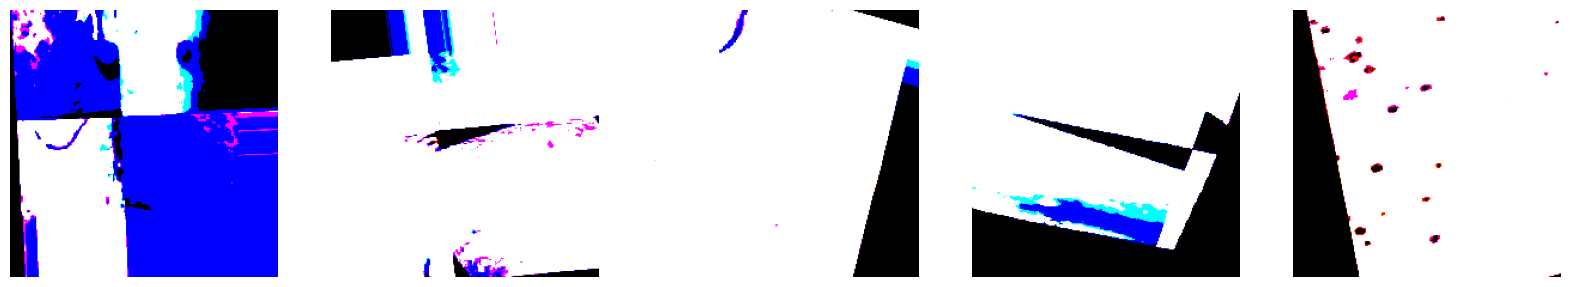

Sample image labels:
Image 1: Papules
Image 2: Pustules
Image 3: Pustules
Image 4: Pustules
Image 5: Blackheads


In [ ]:
# Display basic dataset information
print(f"Classes: {classes}")
print(f"Training images: {train_gen_resnet.n}")
print(f"Validation images: {valid_gen_resnet.n}")
print(f"Testing images: {test_gen_resnet.n}")

# Reset generator to start from first batch
train_gen_resnet.reset()

# Get one batch of training images and labels
images, labels = next(train_gen_resnet)

def plotImages(images):
    """
    Display sample images from the dataset.
    This follows the visualization approach used in cnn.py.
    """
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    for img, ax in zip(images[:5], axes):
        ax.imshow(img)      # Show image
        ax.axis('off')      # Hide axes
    plt.show()

# Show first 5 training images
plotImages(images)

# Display corresponding class labels
print("Sample image labels:")
for i in range(5):
    class_index = np.argmax(labels[i])  # Convert one-hot to class index
    print(f"Image {i+1}: {classes[class_index]}")

2. Model Performance (Model Accuracy & Loss)

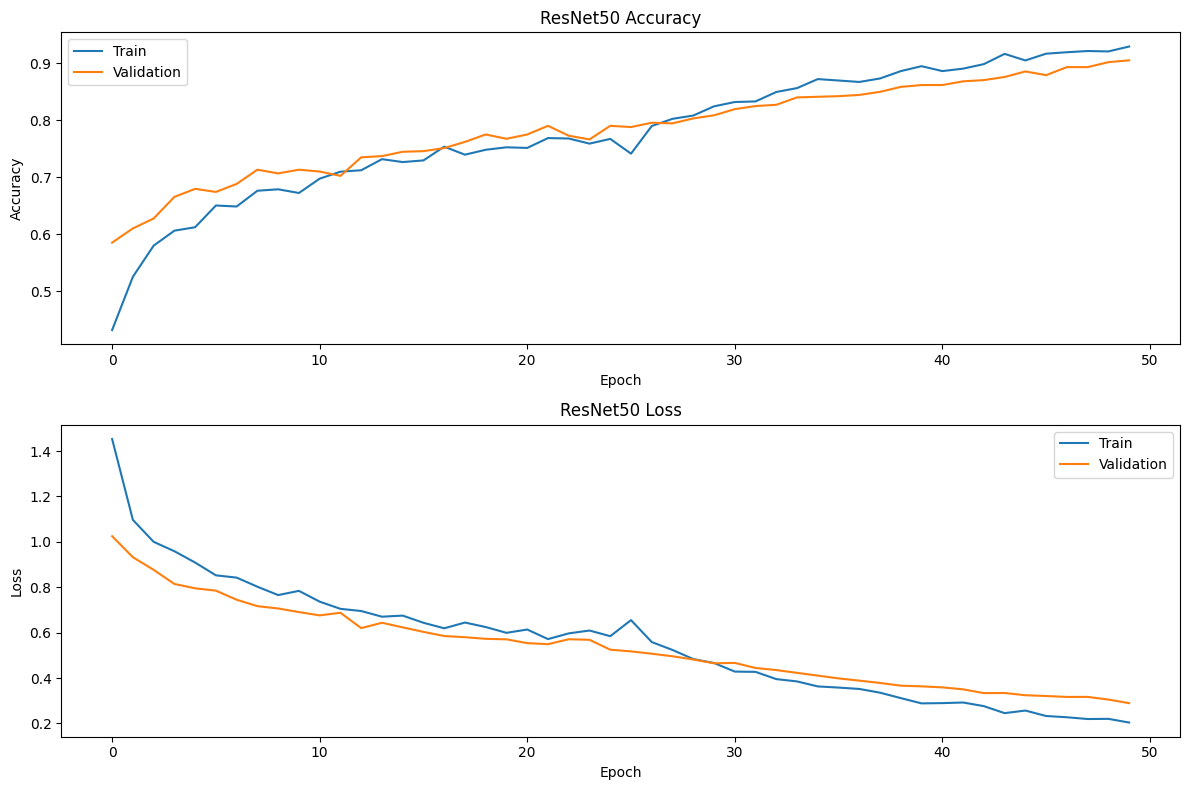

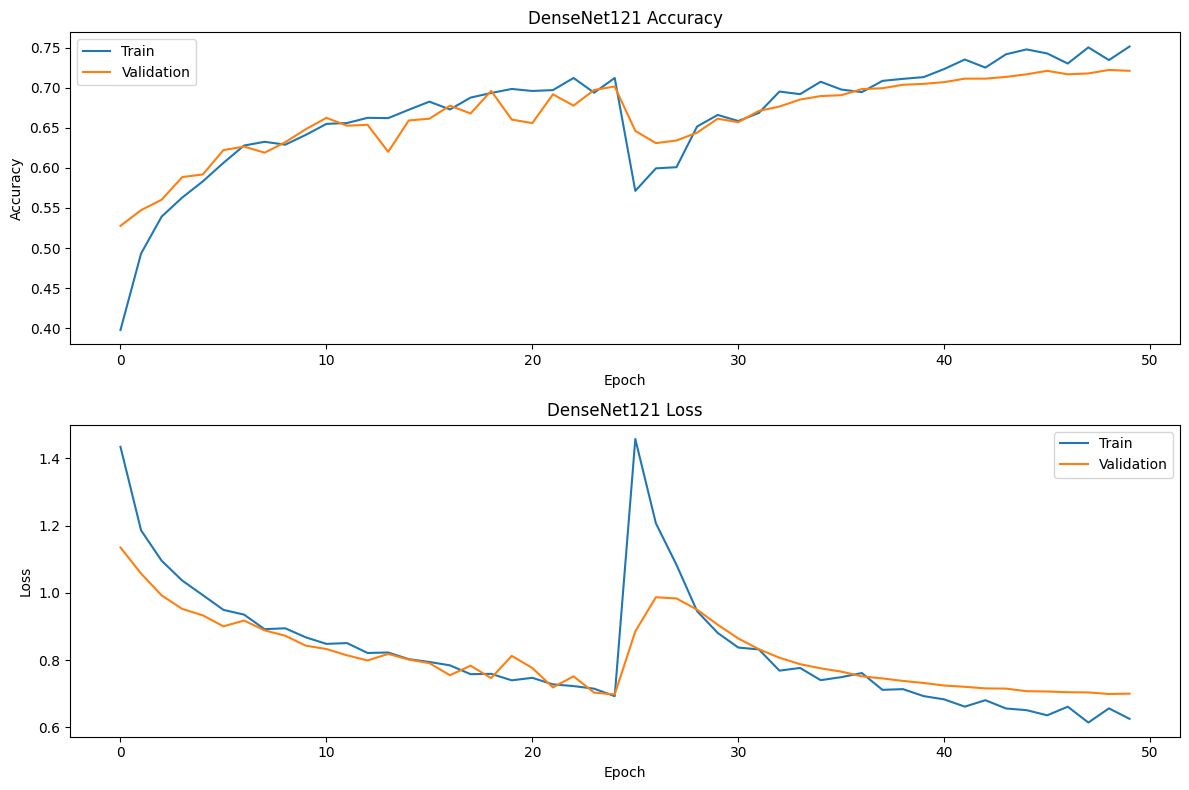

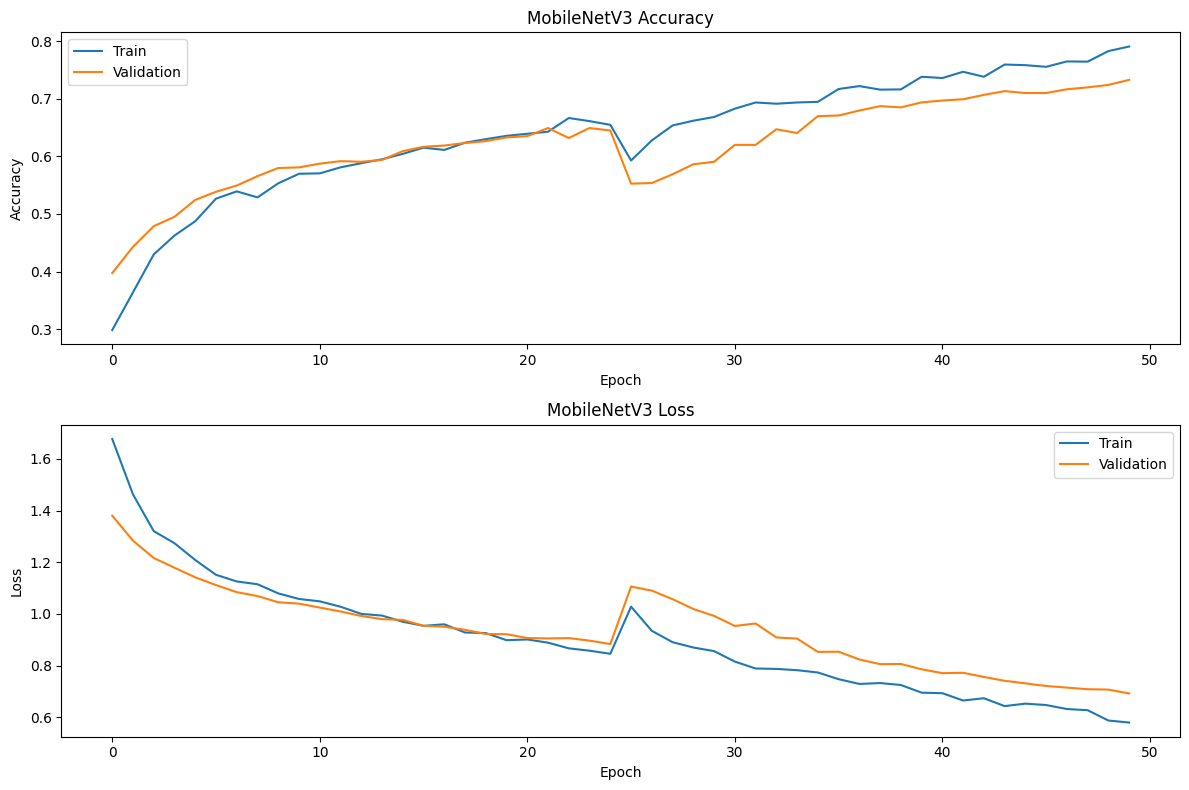

In [ ]:
#Plot training and validation accuracy and loss.
def plot_model_performance(history, model_name):
    plt.figure(figsize=(12, 8))

    # Accuracy plot
    plt.subplot(2, 1, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])

    # Loss plot
    plt.subplot(2, 1, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

# Plot performance for each model
plot_model_performance(resnet_history, "ResNet50")
plot_model_performance(densenet_history, "DenseNet121")
plot_model_performance(mobilenet_history, "MobileNetV3")

3. Confusion Matrix Evaluation

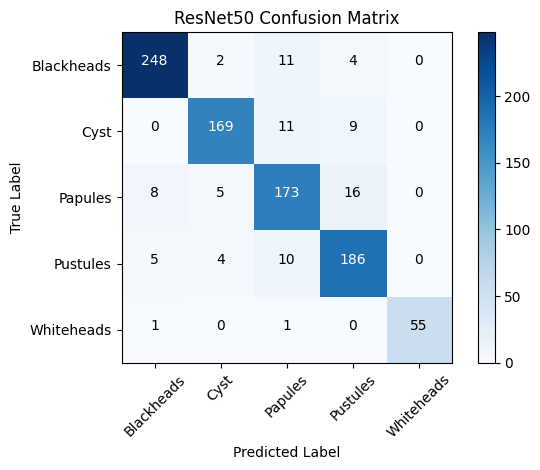

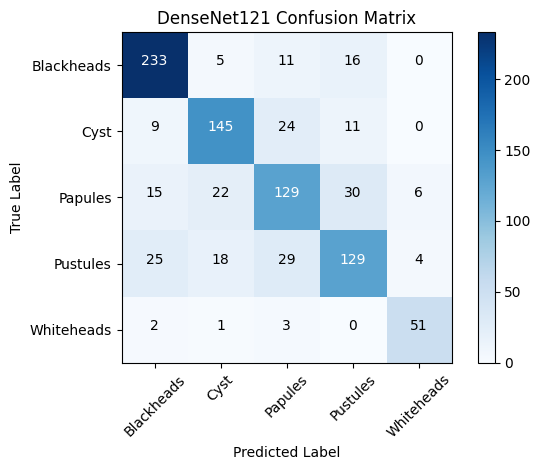

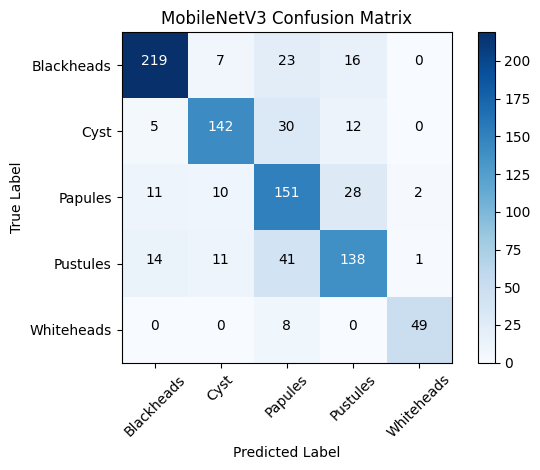

In [ ]:
# Displays predicted vs actual class performance.
def plot_confusion_matrix(cm, classes, title):
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Annotate each cell with its value
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Models and corresponding test generators
models = [
    ("ResNet50", resnet_model, test_gen_resnet),
    ("DenseNet121", densenet_model, test_gen_densenet),
    ("MobileNetV3", mobilenet_model, test_gen_mobilenet)
]

# Generate confusion matrix for each model
for model_name, model, test_gen in models:
    test_gen.reset()
    predictions = np.argmax(model.predict(test_gen, verbose=0), axis=1)
    cm = confusion_matrix(test_gen.classes, predictions)
    plot_confusion_matrix(cm, classes, f"{model_name} Confusion Matrix")

4. Test Dataset Performance (Accuracy & mAP)

In [ ]:
print(f"{'Model':<15}{'Accuracy':<12}{'mAP':<12}{'Time(s)':<10}")
print("-" * 60)

for model_name, model, test_gen in models:
    test_gen.reset()

    # Evaluate accuracy on test dataset
    loss, accuracy = model.evaluate(test_gen, verbose=0)

    # Predict probabilities for mAP calculation
    test_gen.reset()
    predictions = model.predict(test_gen, verbose=0)

    # Convert true labels to one-hot encoding
    y_true = np.eye(len(classes))[test_gen.classes]

    # Compute mean Average Precision (mAP)
    mAP = average_precision_score(y_true, predictions, average='macro')

    # Retrieve training time
    training_time = (
        resnet_training_time if model_name == "ResNet50" else
        densenet_training_time if model_name == "DenseNet121" else
        mobilenet_training_time
    )

    print(f"{model_name:<15}{accuracy:<12.4f}{mAP:<12.4f}{training_time:<10.2f}")

Model          Accuracy    mAP         Time(s)   
------------------------------------------------------------
ResNet50       0.9052      0.9596      4358.30   
DenseNet121    0.7484      0.8534      2642.61   
MobileNetV3    0.7614      0.8595      2459.40   


5. Final Conclusion & Comparison


BEST MODEL FOR ACNE CLASSIFICATION: ResNet50
Accuracy: 0.9052
mAP: 0.9596
Training Time: 72.6 minutes


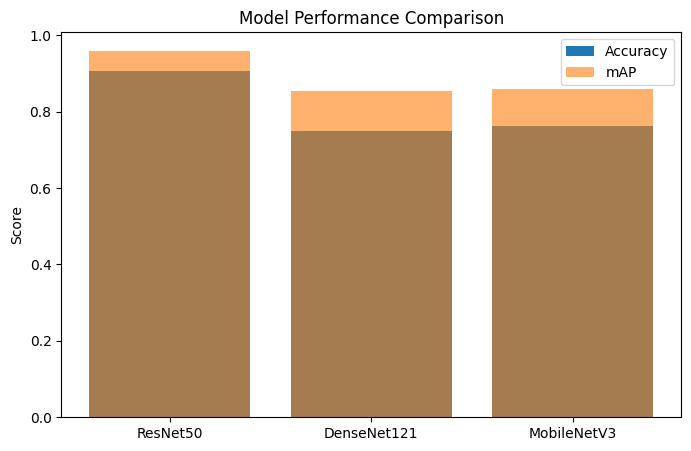

In [ ]:

# Store metrics for comparison
metrics = [
    ("ResNet50", resnet_test_acc, resnet_map, resnet_training_time),
    ("DenseNet121", densenet_test_acc, densenet_map, densenet_training_time),
    ("MobileNetV3", mobilenet_test_acc, mobilenet_map, mobilenet_training_time)
]

# Identify best model based on accuracy
best_model = max(metrics, key=lambda x: x[1])

print("\nBEST MODEL FOR ACNE CLASSIFICATION:", best_model[0])
print(f"Accuracy: {best_model[1]:.4f}")
print(f"mAP: {best_model[2]:.4f}")
print(f"Training Time: {best_model[3]/60:.1f} minutes")

# Visual comparison of accuracy and mAP
model_names = [m[0] for m in metrics]
accuracies = [m[1] for m in metrics]
maps = [m[2] for m in metrics]

plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, label='Accuracy')
plt.bar(model_names, maps, alpha=0.6, label='mAP')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.show()

Based on the experimental results, ResNet50 achieved the highest accuracy (0.9052) and mAP (0.9596), demonstrating the best overall performance for acne classification. Its longer training time (4358.30 s) reflects the higher computational cost due to its larger number of parameters, but this is justified by its superior predictive ability.<br><br>

DenseNet121 showed moderate performance with an accuracy of (0.7484) and mAP of (0.8534), achieving a good trade-off between model complexity and predictive capability. It required less training time (2642.61 s) compared to ResNet50, making it more efficient while still maintaining reasonable performance.<br><br>

MobileNetV3 offered the fastest training (2459.40 s) and lowest model complexity, with an accuracy of (0.7614) and mAP of (0.8595). While its predictive performance is slightly lower than ResNet50, it is well-suited for deployment in environments with limited computational resources.<br><br>

Overall, considering model parameters, accuracy, mAP, and training time, ResNet50 is concluded to be the best-performing model for acne classification in this study.